# Data Analysis for Data-Driven Water Temperature Prediction 

- Analysing the dataset created by run_example.sh
- Modelling statistical predictions



TODO:
 - Tune processing and storing of observational data sets (to suite whatever code that will use the data sets)
 - Prototype naive prediction
 - Prototype linear regression
 - Prototype random forest
 - Prototype simple XGBoost
 - Prototype simple ANN (with Tensorflow and Keras?)
 - ...

In [1]:
import pandas as pd 
import datetime
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
mydates = mdates.DateFormatter('%m-%d')

## Reading and Preprocessing data set 

In [2]:
# Read the example data
data = pd.read_csv("havvarsel-data-driven-pred-data/dataset_4.csv")
N = len(data)

data["time"] = pd.to_datetime(data["time"])
data = data.set_index("time")

years = list(dict.fromkeys(list(data.index.year)))

In [3]:
# NOTE: Some of the libraries require special attention if the data contains NaNs
ignore_nan = False

if ignore_nan:
    # Check the dataset for sanity 
    # i.e. remove columns with only NaN
    for column in data.columns:
        if data[column].isnull().values.any():
            print("Column", column, "gets removed since it contains NaN entries")
            del data[column]

In [4]:
# NOTE: Some columns contain only integer values

# Casting to all entries to floats
for column in data.columns:
    if data[column].dtype != "float64":
        data[column] = data[column].astype(float)

In [5]:
add_prev_temp = False

if add_prev_temp:
    # Adding the previous water_temp as additonal trainings covariate
    data["LASTwater_temp"] = data["water_temp"].shift(1)
    data = data.iloc[1:, :]

In [6]:
# TEMP!!! 
# Offset since last year empty

# Split in train and test data
# where the full last year becomes the test set 
start_train = datetime.datetime.strptime(str(years[0])+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_train = datetime.datetime.strptime(str(years[-1]-2)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
train = data[start_train : end_train]

start_test = datetime.datetime.strptime(str(years[-1]-1)+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_test = datetime.datetime.strptime(str(years[-1]-1)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
test = data[start_test : end_test]

## Data Analysis

Learning a data-driven predictor

In [7]:
def plot_test_vs_truth(prediction, dropna=True):
    """Plotting timeseries of the prediciton against the truth"""
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    # Time series plot
    if dropna:
        axs[0].plot(test["water_temp"].dropna().index, test["water_temp"][test["water_temp"].dropna().index])
        axs[0].plot(test["water_temp"].dropna().index, prediction.loc[test["water_temp"].dropna().index])
    else:
        axs[0].plot(clean_test["water_temp"].index, clean_test["water_temp"])
        axs[0].plot(clean_test["water_temp"].index, prediction)


    axs[0].legend(["truth","prediction"])
    axs[0].set_xlabel("date")
    axs[0].set_ylabel("water_temp [degC]")
    axs[0].set_title("True time series vs predicted on test set")
    axs[0].tick_params(axis='x', rotation=45)

    # Bias plot
    if dropna:
        axs[1].plot(prediction, test["water_temp"], "+")
    else:
        axs[1].plot(prediction, clean_test["water_temp"], "+")
    axs[1].plot(np.linspace(8,24), np.linspace(8,24))

    axs[1].set_xlabel("predicted water_temp [degC]")
    axs[1].set_ylabel("true water_temp [degC]")
    axs[1].set_title("Predicted test vs true test")    


### Naive Prediction

The naive prediction assumes that the `water_temp` does not change

In [8]:
prediction = test["water_temp"].shift(1) 

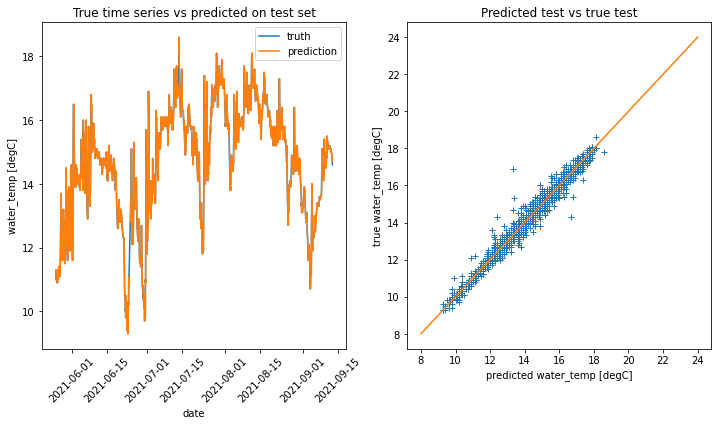

In [9]:
plot_test_vs_truth(prediction)


### NorKyst800 Prediction

Relying on NorKyst800 Forecast without further data analysis


In [10]:
prediction = test["norkyst_water_temp0"]

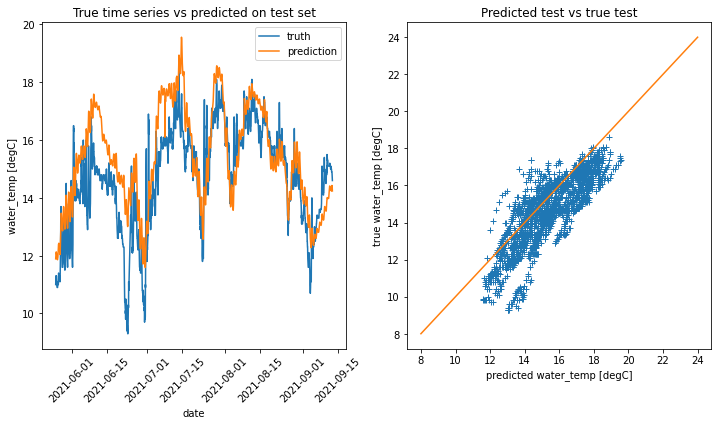

In [11]:
plot_test_vs_truth(prediction)

### Regressoion-Type Algorithms

The atmospheric observations at time $t$, the NorKyst800 forecast for time $t$ and the `water_temp` at time $t-1$ are used as covariates in order to model the `water_temp` at time $t$ as response.

NOTE: 
- the increments between times is different! An additional time difference variable could be useful, but does not make sense additive linear factor (as multiplicative factor maybe more suited - DISCUSS)
- in further work, we aim for atmospheric observations at time $t-1$ and forecasted atmospheric elements at time $t$

In [12]:
clean_data = data.dropna()
clean_train = clean_data[start_train : end_train]
clean_test  = clean_data[start_test  : end_test ]

In [13]:
# Covariates and response
X = clean_train.loc[:, data.columns!="water_temp"]
Y = clean_train["water_temp"]

#### Linear Regression


In [14]:
from sklearn.linear_model import LinearRegression

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X,Y)

LinearRegression()

In [15]:
# Test model
prediction_labels = linreg.predict(clean_test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = clean_test.index
prediction = prediction.set_index("time")

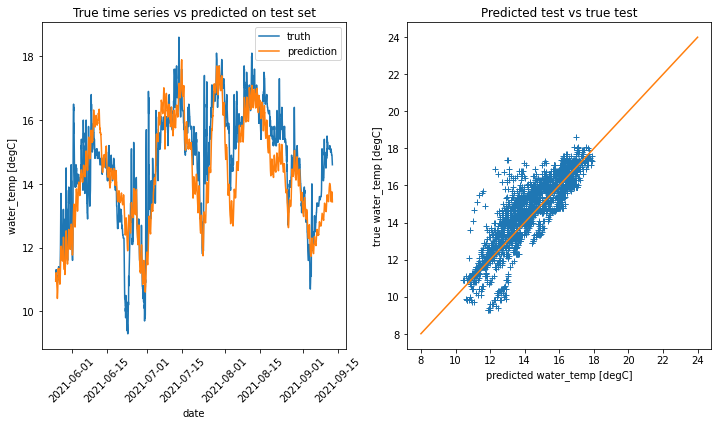

In [16]:
plot_test_vs_truth(prediction, dropna=False)

#### Linear Regression with Autoregressive Error 

Inspecting auto correlation in the dataset (ignoring that there may are temporal gaps)

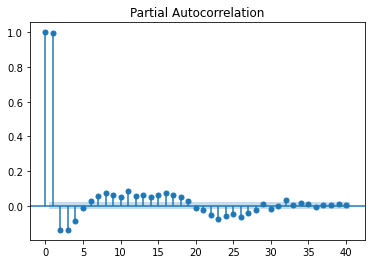

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf = plot_pacf(clean_data["water_temp"])

AR(1) process as error 

Disabled:
- no averaging 
- no lag in explanatory covariates 
- no seasonality 

In [18]:
import statsmodels.api as sm

armax = sm.tsa.statespace.SARIMAX(Y, X, order=(1,0,0))
armax_fit = armax.fit(disp=False)

/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [19]:
armax_forecast = armax_fit.get_forecast(len(clean_test), exog=clean_test.loc[:, clean_test.columns != "water_temp"])

/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [20]:
prediction = pd.DataFrame(data={"time": clean_test.index, "0":armax_forecast.predicted_mean}).set_index("time")

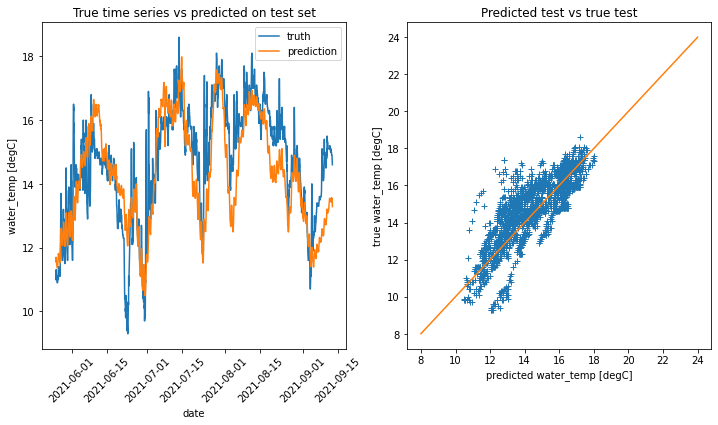

In [21]:
plot_test_vs_truth(prediction, dropna=False)

#### Random Forest

We use all default settings (`n_ensembles` aka the number of trees = 100, `max_features` aka the number of features to split on = sqrt(n_features))

In [22]:
from sklearn.ensemble import RandomForestRegressor
# train model
rf = RandomForestRegressor()
rf.fit(X,Y)

RandomForestRegressor()

In [23]:
# Test model
prediction_labels = rf.predict(clean_test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = clean_test.index
prediction = prediction.set_index("time")

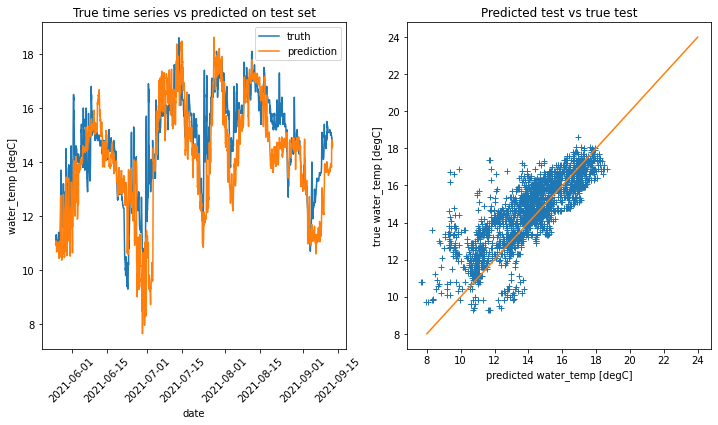

In [24]:
plot_test_vs_truth(prediction, dropna=False)

In [25]:
importance_values = rf.feature_importances_
importance = pd.DataFrame(importance_values, columns=["importance"])
importance["element"] = X.columns
importance = importance.set_index("element")
importance = importance.sort_values(by="importance", ascending=False)
importance

,importance
element,
norkyst_water_temp3,0.526023
norkyst_water_temp0,0.401356
norkyst_water_temp10,0.035082
air_temperature_2m,0.013582
wind_direction_10m,0.012201
wind_speed_10m,0.006057
cloud_area_fraction,0.002673
integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time,0.002392
precipitation_amount,0.000635


#### XGBoost

Using only default, however parameter tuning would be important for boosting though.


In [26]:
from xgboost import XGBRegressor
# train model
xgb = XGBRegressor()
xgb.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
# Test model
prediction_labels = xgb.predict(clean_test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = clean_test.index
prediction = prediction.set_index("time")

/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


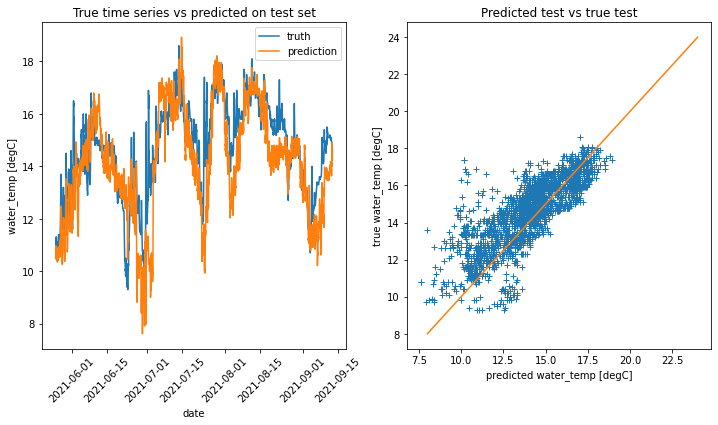

In [28]:
plot_test_vs_truth(prediction, dropna=False)

### Neural Nets

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# NOTE: without a normalizer the results are shifted
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

# Building the neural net
# NOTE: The design of the net has major influence on the results!
# For details see documentation of tensorflow
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(5),
    layers.Dense(units=1)
])

# Configuring with loss function and optimization algorithm
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Training
# NOTE: The training results are very random such that the results from every run are fundamentally different
model.fit(X, Y,
    epochs=200,
    verbose=0,
    validation_split = 0.2)

In [30]:
#test
prediction_labels = model.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

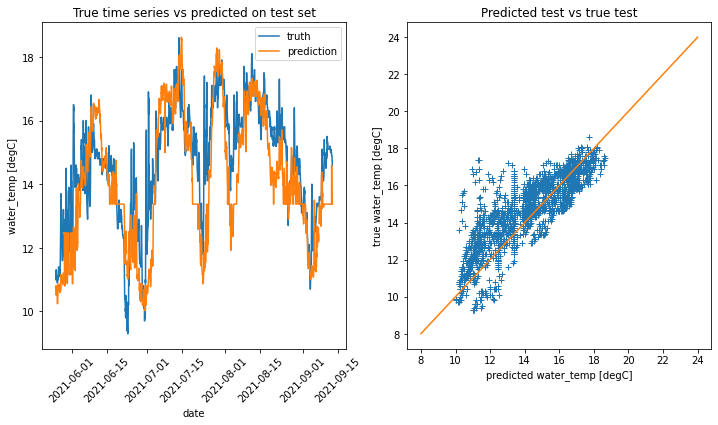

In [31]:
plot_test_vs_truth(prediction)

#### LSTM 

ATTENTION: Downgrading of numpy was required for LSTM!

In [32]:
np.__version__

'1.19.5'

In [33]:
X_array = np.array(X)
X_array = X_array.reshape((X_array.shape[0],1,X_array.shape[1]))

Y_array = np.array(Y)

In [34]:
# TODO: Normalize data!

In [35]:
model = tf.keras.Sequential()
model.add(layers.LSTM(32, return_sequences=True, input_shape=(1,9)))
model.add(layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
model.fit(X_array, Y_array, epochs=100)

Epoch 1/100
210/210 [==============================] - 2s 2ms/step - loss: 190.8005
Epoch 2/100
210/210 [==============================] - 0s 2ms/step - loss: 130.9686
Epoch 3/100
210/210 [==============================] - 0s 2ms/step - loss: 87.3764
Epoch 4/100
210/210 [==============================] - 0s 2ms/step - loss: 44.0094
Epoch 5/100
210/210 [==============================] - 0s 2ms/step - loss: 21.2076
Epoch 6/100
210/210 [==============================] - 0s 2ms/step - loss: 16.4839
Epoch 7/100
210/210 [==============================] - 0s 2ms/step - loss: 10.9851
Epoch 8/100
210/210 [==============================] - 0s 2ms/step - loss: 11.2384
Epoch 9/100
210/210 [==============================] - 0s 2ms/step - loss: 9.0513
Epoch 10/100
210/210 [==============================] - 0s 2ms/step - loss: 7.6516
Epoch 11/100
210/210 [==============================] - 0s 2ms/step - loss: 7.8111
Epoch 12/100
210/210 [==============================] - 0s 2ms/step - loss: 7.1813
Epo

In [37]:
test_array = np.array(clean_test.loc[:, data.columns!="water_temp"])
test_array = test_array.reshape((test_array.shape[0],1,test_array.shape[1]))

prediction = model.predict(test_array).flatten()

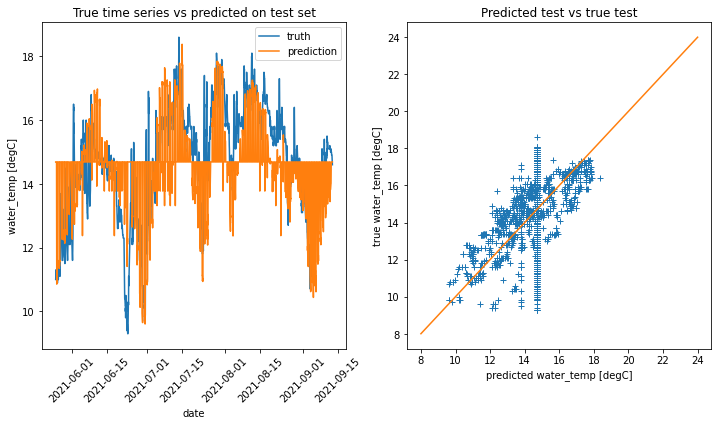

In [39]:
plot_test_vs_truth(prediction, dropna=False)